Geometry: NDBR50, Epoch [100/1000], Loss: 42443.4766
Geometry: NDBR50, Epoch [200/1000], Loss: 42377.3984
Geometry: NDBR50, Epoch [300/1000], Loss: 42305.6992
Geometry: NDBR50, Epoch [400/1000], Loss: 42326.3438
Geometry: NDBR50, Epoch [500/1000], Loss: 42039.4766
Geometry: NDBR50, Epoch [600/1000], Loss: 41857.3984
Geometry: NDBR50, Epoch [700/1000], Loss: 41625.3164
Geometry: NDBR50, Epoch [800/1000], Loss: 41332.8633
Geometry: NDBR50, Epoch [900/1000], Loss: 41064.3477
Geometry: NDBR50, Epoch [1000/1000], Loss: 40605.7070
Geometry: NDBR20, Epoch [100/1000], Loss: 38707.1523
Geometry: NDBR20, Epoch [200/1000], Loss: 41465.3867
Geometry: NDBR20, Epoch [300/1000], Loss: 37765.9141
Geometry: NDBR20, Epoch [400/1000], Loss: 36948.1016
Geometry: NDBR20, Epoch [500/1000], Loss: 35963.4922
Geometry: NDBR20, Epoch [600/1000], Loss: 35778.4922
Geometry: NDBR20, Epoch [700/1000], Loss: 34571.0469
Geometry: NDBR20, Epoch [800/1000], Loss: 34983.6016
Geometry: NDBR20, Epoch [900/1000], Loss: 337

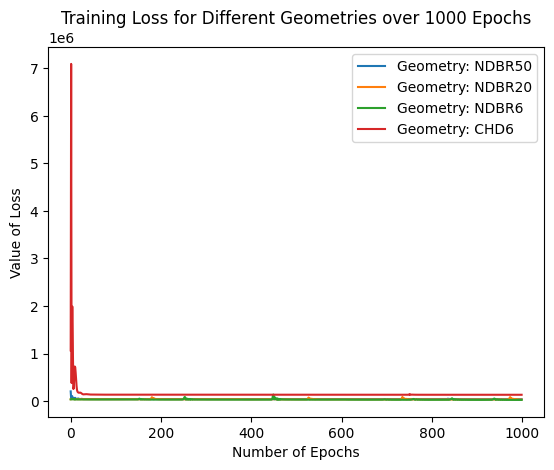

Predicted parameters for geometry NDBR50:
[-2.0908002853393555, 821.4876098632812, -0.3943985402584076, 1.1756755113601685, 798.8353271484375, 437.2702941894531, 447.8891906738281]
Predicted parameters for geometry NDBR20:
[-2.4854519367218018, 794.5040893554688, -0.9185742139816284, 1.5916281938552856, 775.7066040039062, 422.9457702636719, 436.6478576660156]
Predicted parameters for geometry NDBR6:
[-2.024695873260498, 827.9898681640625, -0.2886079251766205, 1.0796643495559692, 804.4560546875, 440.7032165527344, 450.6863708496094]
Predicted parameters for geometry CHD6:
[-2.0211970806121826, 828.40625, -0.2825697362422943, 1.073574185371399, 804.8152465820312, 440.92205810546875, 450.8662109375]


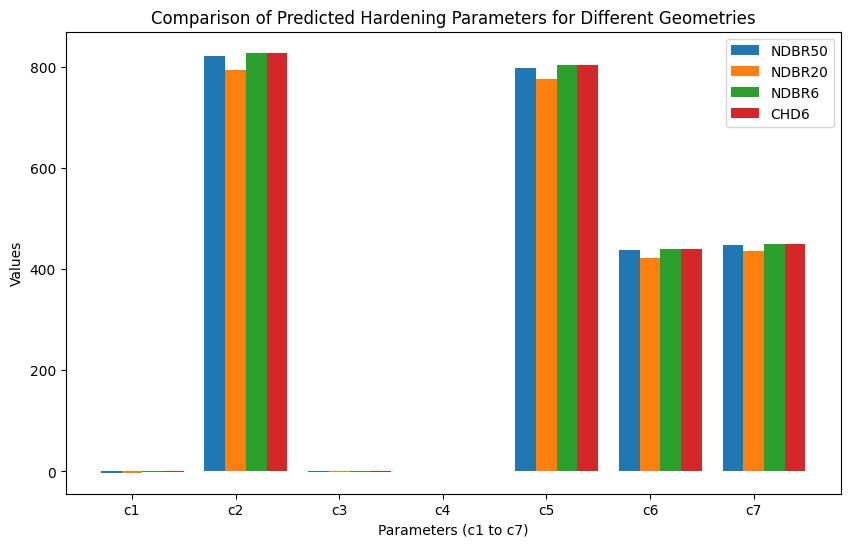

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the geometries and yielding indices
geometries = ['NDBR50', 'NDBR20', 'NDBR6', 'CHD6']
yieldingIndices = {'NDBR50': 200, 'NDBR20': 200, 'NDBR6': 200, 'CHD6': 1200}

# Load data from CSV files
X_files = {
    'NDBR50': "MODEL_DATA/NEWDATA/newData_NDBR50_FD.csv",
    'NDBR20': "MODEL_DATA/NEWDATA/newData_NDBR20_FD.csv",
    'NDBR6': "MODEL_DATA/NEWDATA/newData_NDBR6_FD.csv",
    'CHD6': "MODEL_DATA/NEWDATA/newData_CHD6_FD.csv"
}

Y_file = "MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv"

X_data = {geometry: pd.read_csv(X_files[geometry], usecols=[0, 1]).values for geometry in geometries}
Y_data = pd.read_csv(Y_file).values

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_size = 2  # Number of input parameters (force and displacement)
hidden_size1 = 256  # Number of units in the first hidden layer
hidden_size2 = 256  # Number of units in the second hidden layer
output_size = 7  # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Define a loss function (mean squared error) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

# Lists to store loss values for each geometry
loss_lists = {geometry: [] for geometry in geometries}

for geometry in geometries:
    num_samples = yieldingIndices[geometry]
    X_sample = torch.tensor(X_data[geometry], dtype=torch.float32)[:num_samples]
    Y_sample = torch.tensor(Y_data, dtype=torch.float32)[:num_samples]

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss
        loss = criterion(outputs, Y_sample)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_lists[geometry].append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss for each geometry in a single graph
for geometry in geometries:
    plt.plot(loss_lists[geometry], label=f'Geometry: {geometry}')

plt.xlabel('Number of Epochs')
plt.ylabel('Value of Loss')
plt.legend()
plt.title('Training Loss for Different Geometries over 1000 Epochs')
plt.show()

# Predict parameters for all geometries
predicted_parameters = {}

for geometry in geometries:
    X_test = torch.tensor(X_data[geometry][:1], dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_test)

    predicted_parameters[geometry] = predictions[0].tolist()

# Print predicted parameters for all geometries
for geometry, params in predicted_parameters.items():
    print(f'Predicted parameters for geometry {geometry}:')
    print(params)

# Visualize 'c1' to 'c7' values for each geometry in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = [predicted_parameters[geometry] for geometry in geometries]

plt.figure(figsize=(10, 6))
for i, geometry in enumerate(geometries):
    plt.bar(np.arange(len(param_names)) + i * 0.2, param_values[i], width=0.2, label=f'{geometry}')

plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Comparison of Predicted Hardening Parameters for Different Geometries')
plt.xticks(np.arange(len(param_names)) + 0.2, param_names)
plt.legend()
plt.show()


Geometry: NDBR50, Epoch [100/10000], Loss: 137460.2969
Geometry: NDBR50, Epoch [200/10000], Loss: 137419.8750
Geometry: NDBR50, Epoch [300/10000], Loss: 137366.8750
Geometry: NDBR50, Epoch [400/10000], Loss: 137167.5156
Geometry: NDBR50, Epoch [500/10000], Loss: 140059.9219
Geometry: NDBR50, Epoch [600/10000], Loss: 139666.5000
Geometry: NDBR50, Epoch [700/10000], Loss: 134711.8281
Geometry: NDBR50, Epoch [800/10000], Loss: 133465.8125
Geometry: NDBR50, Epoch [900/10000], Loss: 132744.5312
Geometry: NDBR50, Epoch [1000/10000], Loss: 132907.0781
Geometry: NDBR50, Epoch [1100/10000], Loss: 132781.2500
Geometry: NDBR50, Epoch [1200/10000], Loss: 132623.2656
Geometry: NDBR50, Epoch [1300/10000], Loss: 132384.4844
Geometry: NDBR50, Epoch [1400/10000], Loss: 134761.1406
Geometry: NDBR50, Epoch [1500/10000], Loss: 132718.4062
Geometry: NDBR50, Epoch [1600/10000], Loss: 132621.8438
Geometry: NDBR50, Epoch [1700/10000], Loss: 132487.8125
Geometry: NDBR50, Epoch [1800/10000], Loss: 132289.2656
G

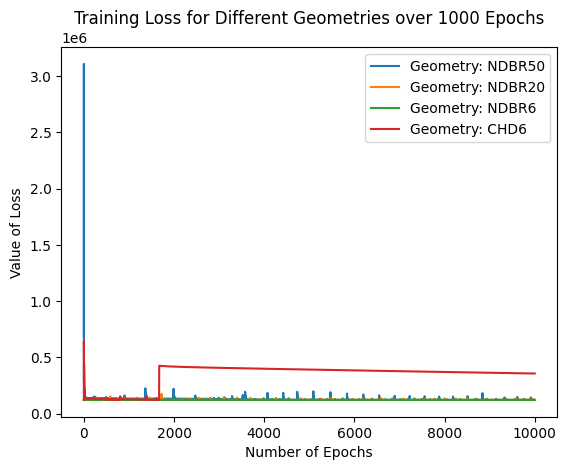

Predicted parameters for geometry NDBR50:
[-0.2661072015762329, 773.9391479492188, -0.2958686053752899, 0.4145490527153015, 1397.3394775390625, 346.606201171875, 411.70721435546875]
Predicted parameters for geometry NDBR20:
[-3.244802474975586, 948.92236328125, -0.7724286913871765, 0.2576442360877991, 1103.5792236328125, 410.57421875, 417.1749267578125]
Predicted parameters for geometry NDBR6:
[0.5984548330307007, 723.3970336914062, -0.15824148058891296, 0.47073429822921753, 1481.636474609375, 328.0909423828125, 410.05511474609375]
Predicted parameters for geometry CHD6:
[0.6563910245895386, 720.0103149414062, -0.14901897311210632, 0.4745010733604431, 1487.2852783203125, 326.85028076171875, 409.9444580078125]


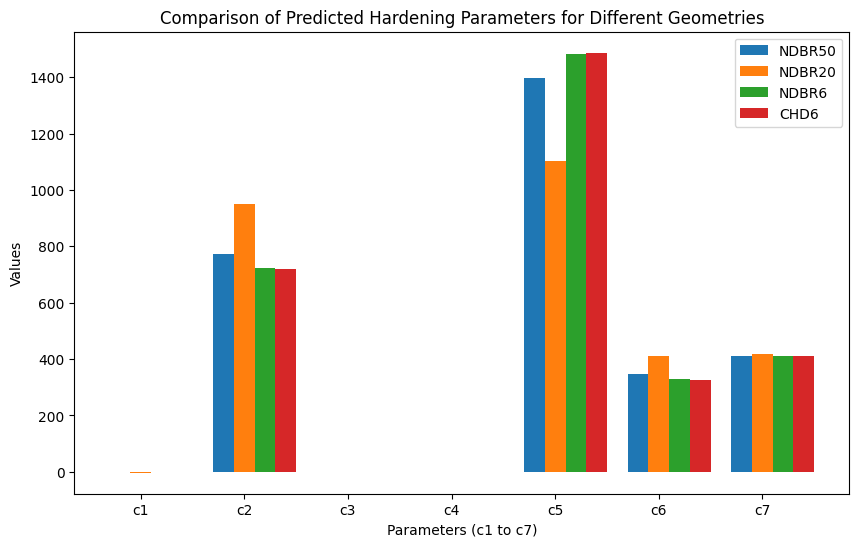

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the geometries and yielding indices
geometries = ['NDBR50', 'NDBR20', 'NDBR6', 'CHD6']
yieldingIndices = {'NDBR50': 200, 'NDBR20': 200, 'NDBR6': 200, 'CHD6': 1200}

# Load data from CSV files
X_files = {
    'NDBR50': "MODEL_DATA/NEWDATA/newData_NDBR50_FD.csv",
    'NDBR20': "MODEL_DATA/NEWDATA/newData_NDBR20_FD.csv",
    'NDBR6': "MODEL_DATA/NEWDATA/newData_NDBR6_FD.csv",
    'CHD6': "MODEL_DATA/NEWDATA/newData_CHD6_FD.csv"
}

Y_file = "MODEL_DATA/NEWDATA/newData_HardParam.csv"

X_data = {geometry: pd.read_csv(X_files[geometry], usecols=[0, 1]).values for geometry in geometries}
Y_data = pd.read_csv(Y_file).values

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_size = 2  # Number of input parameters (force and displacement)
hidden_size1 = 256  # Number of units in the first hidden layer
hidden_size2 = 128  # Number of units in the second hidden layer
output_size = 7  # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Define a loss function (mean squared error) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

# Lists to store loss values for each geometry
loss_lists = {geometry: [] for geometry in geometries}

for geometry in geometries:
    num_samples = min(yieldingIndices[geometry], len(Y_data))
    X_sample = torch.tensor(X_data[geometry][:num_samples], dtype=torch.float32)
    Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss
        loss = criterion(outputs, Y_sample)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_lists[geometry].append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss for each geometry in a single graph
for geometry in geometries:
    plt.plot(loss_lists[geometry], label=f'Geometry: {geometry}')

plt.xlabel('Number of Epochs')
plt.ylabel('Value of Loss')
plt.legend()
plt.title('Training Loss for Different Geometries over 1000 Epochs')
plt.show()

# Predict parameters for all geometries
predicted_parameters = {}

for geometry in geometries:
    X_test = torch.tensor(X_data[geometry][:1], dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_test)

    predicted_parameters[geometry] = predictions[0].tolist()

# Print predicted parameters for all geometries
for geometry, params in predicted_parameters.items():
    print(f'Predicted parameters for geometry {geometry}:')
    print(params)

# Visualize 'c1' to 'c7' values for each geometry in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = [predicted_parameters[geometry] for geometry in geometries]

plt.figure(figsize=(10, 6))
for i, geometry in enumerate(geometries):
    plt.bar(np.arange(len(param_names)) + i * 0.2, param_values[i], width=0.2, label=f'{geometry}')

plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Comparison of Predicted Hardening Parameters for Different Geometries')
plt.xticks(np.arange(len(param_names)) + 0.2, param_names)
plt.legend()
plt.show()


Geometry: NDBR50, Epoch [100/10000], Loss: 42434.0039
Geometry: NDBR50, Epoch [200/10000], Loss: 42340.3867
Geometry: NDBR50, Epoch [300/10000], Loss: 42238.5820
Geometry: NDBR50, Epoch [400/10000], Loss: 42106.7539
Geometry: NDBR50, Epoch [500/10000], Loss: 51319.4062
Geometry: NDBR50, Epoch [600/10000], Loss: 41988.1406
Geometry: NDBR50, Epoch [700/10000], Loss: 42232.5977
Geometry: NDBR50, Epoch [800/10000], Loss: 41828.5273
Geometry: NDBR50, Epoch [900/10000], Loss: 44679.9297
Geometry: NDBR50, Epoch [1000/10000], Loss: 41550.9961
Geometry: NDBR50, Epoch [1100/10000], Loss: 41245.1484
Geometry: NDBR50, Epoch [1200/10000], Loss: 41958.7695
Geometry: NDBR50, Epoch [1300/10000], Loss: 40933.4219
Geometry: NDBR50, Epoch [1400/10000], Loss: 40611.1602
Geometry: NDBR50, Epoch [1500/10000], Loss: 40271.1445
Geometry: NDBR50, Epoch [1600/10000], Loss: 40350.2617
Geometry: NDBR50, Epoch [1700/10000], Loss: 38664.0234
Geometry: NDBR50, Epoch [1800/10000], Loss: 37192.9766
Geometry: NDBR50, E

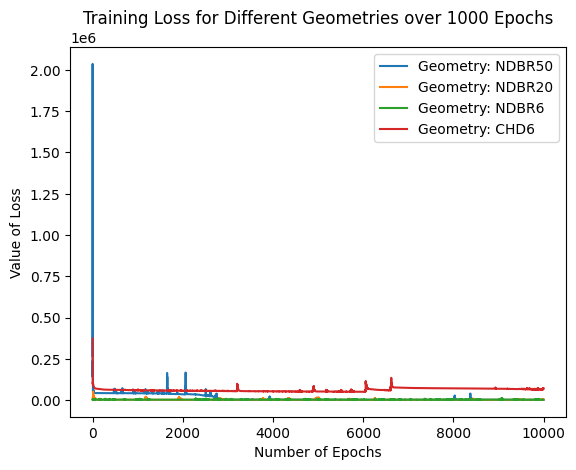

Predicted parameters for geometry NDBR50:
[0.8837409019470215, 817.72509765625, 0.03469580411911011, 0.6084690690040588, 1275.1719970703125, 349.47979736328125, 571.882568359375]
Predicted parameters for geometry NDBR20:
[0.5540151596069336, 859.2865600585938, -0.5881642699241638, 0.6598519086837769, 1599.7359619140625, 417.9820556640625, 650.7568969726562]
Predicted parameters for geometry NDBR6:
[0.8417830467224121, 820.2614135742188, 0.03960996866226196, 0.6225643157958984, 1149.0599365234375, 329.05010986328125, 545.6671142578125]
Predicted parameters for geometry CHD6:
[0.8389737606048584, 820.4312744140625, 0.03993856906890869, 0.6235079765319824, 1140.6168212890625, 327.682373046875, 543.9119873046875]


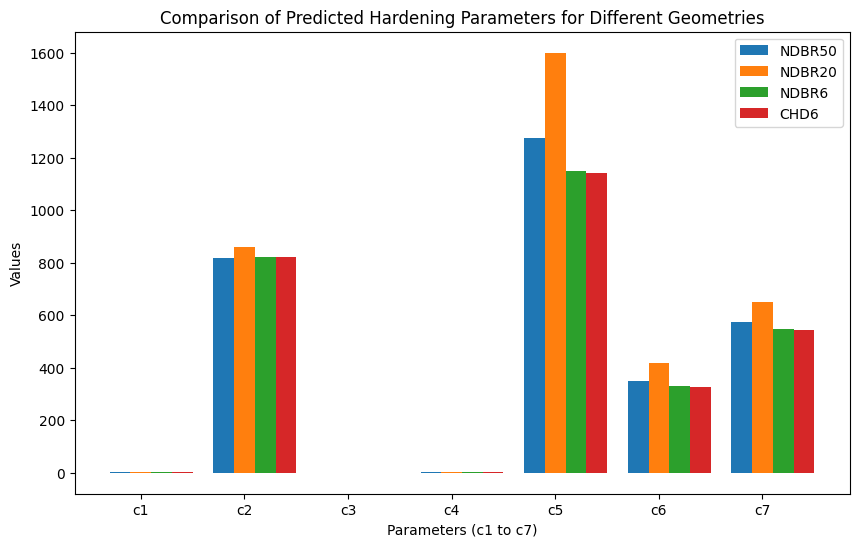

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the geometries and yielding indices
geometries = ['NDBR50', 'NDBR20', 'NDBR6', 'CHD6']
yieldingIndices = {'NDBR50': 200, 'NDBR20': 200, 'NDBR6': 200, 'CHD6': 1200}

# Load data from CSV files
X_files = {
    'NDBR50': "MODEL_DATA/NEWDATA/newData_NDBR50_FD.csv",
    'NDBR20': "MODEL_DATA/NEWDATA/newData_NDBR20_FD.csv",
    'NDBR6': "MODEL_DATA/NEWDATA/newData_NDBR6_FD.csv",
    'CHD6': "MODEL_DATA/NEWDATA/newData_CHD6_FD.csv"
}

Y_file = "MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv"

X_data = {geometry: pd.read_csv(X_files[geometry], usecols=[0, 1]).values for geometry in geometries}
Y_data = pd.read_csv(Y_file).values

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size4, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

input_size = 2  # Number of input parameters (force and displacement)
hidden_size1 = 256  # Number of units in the first hidden layer
hidden_size2 = 256  # Number of units in the second hidden layer
hidden_size3 = 128  # Number of units in the third hidden layer
hidden_size4 = 64   # Number of units in the fourth hidden layer
output_size = 7    # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)


# Define a loss function (mean squared error) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

# Lists to store loss values for each geometry
loss_lists = {geometry: [] for geometry in geometries}

for geometry in geometries:
    num_samples = min(yieldingIndices[geometry], len(Y_data))
    X_sample = torch.tensor(X_data[geometry][:num_samples], dtype=torch.float32)
    Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss
        loss = criterion(outputs, Y_sample)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_lists[geometry].append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss for each geometry in a single graph
for geometry in geometries:
    plt.plot(loss_lists[geometry], label=f'Geometry: {geometry}')

plt.xlabel('Number of Epochs')
plt.ylabel('Value of Loss')
plt.legend()
plt.title('Training Loss for Different Geometries over 1000 Epochs')
plt.show()

# Predict parameters for all geometries
predicted_parameters = {}

for geometry in geometries:
    X_test = torch.tensor(X_data[geometry][:1], dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_test)

    predicted_parameters[geometry] = predictions[0].tolist()

# Print predicted parameters for all geometries
for geometry, params in predicted_parameters.items():
    print(f'Predicted parameters for geometry {geometry}:')
    print(params)

# Visualize 'c1' to 'c7' values for each geometry in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = [predicted_parameters[geometry] for geometry in geometries]

plt.figure(figsize=(10, 6))
for i, geometry in enumerate(geometries):
    plt.bar(np.arange(len(param_names)) + i * 0.2, param_values[i], width=0.2, label=f'{geometry}')

plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Comparison of Predicted Hardening Parameters for Different Geometries')
plt.xticks(np.arange(len(param_names)) + 0.2, param_names)
plt.legend()
plt.show()
